# Machine Listening (Fall 2020)
# Lab2: Acoustic Feature Extraction

# lab2 - 1 : Spectral features (Spectral centroid & Spectral spread & Spectral flatness & Spectral envelope & MFCC)

import libraries

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import scipy



get authorization to read audio files in google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


read audio file

In [17]:
audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab2/wav/T39-piano.wav'
#audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab2/wav/T08-violin.wav'
# audio_path = '/content/drive/My Drive/machine_listening_2020/lab/lab2/wav/speechbeach1.wav'

audio, sr = librosa.load(audio_path, sr=None)
print('sample rate of this audio file :', sr, 'Hz')
ipd.Audio(audio, rate=sr, autoplay=False) # play audio

sample rate of this audio file : 44100 Hz


plot waveform of audio file

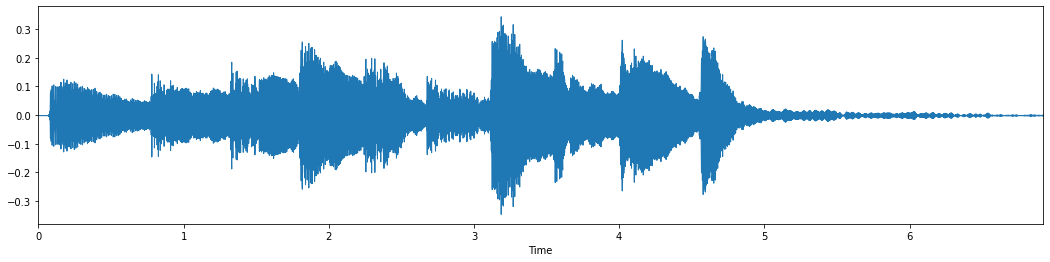

In [18]:
plt.figure(figsize=(18,4))
librosa.display.waveplot(audio, sr)
plt.show()

compute spectrogram

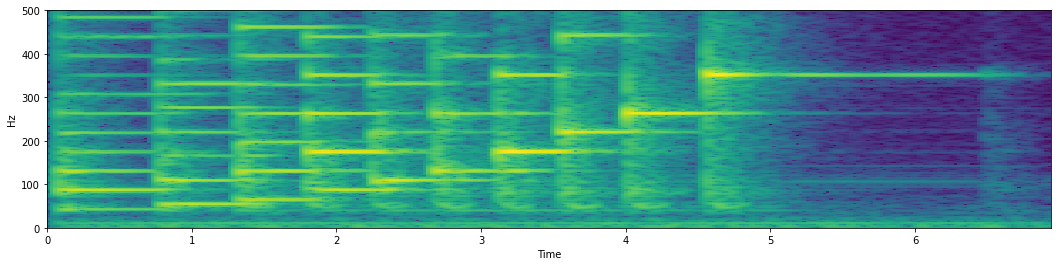

8192


In [38]:
n_fft = int(np.power(2, np.ceil(np.log2(np.abs(int(sr*0.1))))))
# n_fft == 8192
spec, phase = librosa.magphase(librosa.stft(audio, n_fft=n_fft, win_length = n_fft, hop_length = int(n_fft - 7*n_fft/8), window='hann'))
nframe = len(spec[0])

plt.figure(figsize=(18,4))
librosa.display.specshow(np.log(spec + 0.001), cmap='viridis', x_axis='time', y_axis='linear')
plt.ylim(0,500)
plt.show()
print(n_fft)

compute spectral centroid (SC) and spectral spread (SS)

In [20]:
fi = np.linspace(0,int(sr/2),int(n_fft/2))

sc = []
ss = []

for i in range(0,nframe):
  X = spec[:-1,i]
  sc.append(np.sum(np.multiply(fi,np.power(np.abs(X),2)))/np.sum(np.power(np.abs(X),2)))
  ss.append(np.sqrt(np.sum(np.power(np.subtract(fi,sc[i]),2)*np.power(np.abs(X),2))/np.sum(np.power(np.abs(X),2))))
                    
                    

plot spectral centroid (SC) and spectral spread (SS)

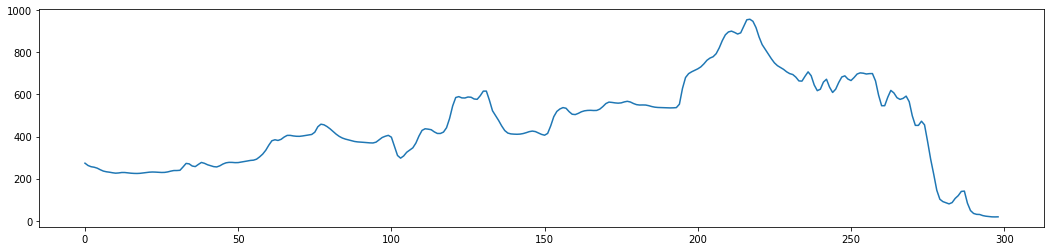

In [21]:
plt.figure(figsize=(18,4))
plt.plot(sc)
plt.show()

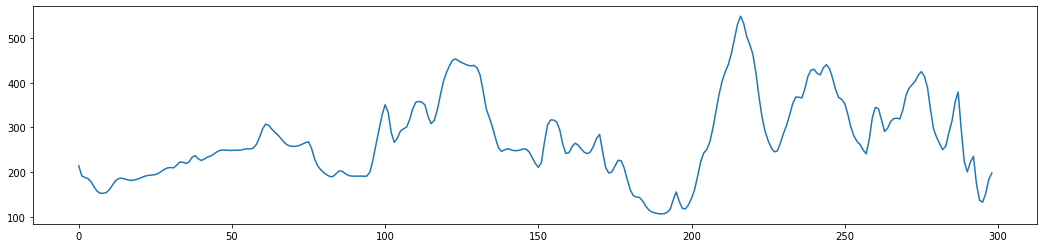

In [22]:
plt.figure(figsize=(18,4))
plt.plot(ss)
plt.show()

compute spectral flatness (SF)

In [23]:
# SF is a subband-based feature (SF_b where b is a band)
# first compute filterbank frequencies using bark band (critical band)
bf = [0, 100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500, 20000] # bark band frequencies
nband = len(bf)-1 # number of subbands


bf_idx = []
for i in range(0,nband):
  temp = np.abs(bf[i+1]-fi)
  bf_idx.append([j for (j, val) in enumerate(temp) if val == np.min(np.abs(bf[i+1]-fi))][0])

n_b = [bf_idx[0]]
for i in range(0,nband-1):
  n_b.append(bf_idx[i+1]-bf_idx[i]+1)
  
ff = []
for i in range(0,nband):
  if i == 0:
    ff.append(list(range(1,bf_idx[i])))
  else:
    ff.append(list(range(bf_idx[i-1]+1,bf_idx[i])))

sf = np.zeros((18,nframe))
for i in range(0,nframe):
  X = spec[:-1,i]
  for j in range(0,18):
    # (geometric mean)/(arithmetic mean)
    sf[j,i] = np.power(np.prod(np.power(np.add(np.abs([X[k] for k in ff[j]]),np.finfo(float).eps),2)),1/n_b[j])/(np.sum(np.power(np.add(np.abs([X[k] for k in ff[j]]),np.finfo(float).eps),2))/n_b[j])

    
sfm = []
for i in range(0,nframe):
  temp = sf[:,i]
  sfm.append(np.mean(temp[np.isfinite(temp)]))

print(sfm)

[0.15855504939188914, 0.39923755866819666, 0.32112205895979745, 0.23308428990686123, 0.1977546680387018, 0.14598173160928452, 0.09214324043694483, 0.07436274116921052, 0.05919729825334295, 0.052711231731757215, 0.045335132996668595, 0.03421505351820474, 0.023798654673708966, 0.016756233507493907, 0.016310802929569778, 0.01389343103039588, 0.011765155964006298, 0.007577565481173683, 0.006741274450871497, 0.006596492630050198, 0.005934377422112109, 0.0063822899371897375, 0.005321203197881569, 0.004703596609164737, 0.004079049948516276, 0.003476627783520133, 0.003037994178903938, 0.003803208346468435, 0.003501902669569701, 0.002758243908908409, 0.006919825845722089, 0.09282341228487047, 0.1740147093224083, 0.1620099473249637, 0.13333377481866618, 0.09532379866950663, 0.06681198410656225, 0.049751441995364326, 0.036500748380224574, 0.02922275923043803, 0.03212609535053504, 0.03502960090055943, 0.03464183384371847, 0.031795183625448746, 0.02498888586564768, 0.022057853844804607, 0.018941066

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


plot spectral flatness (SF)

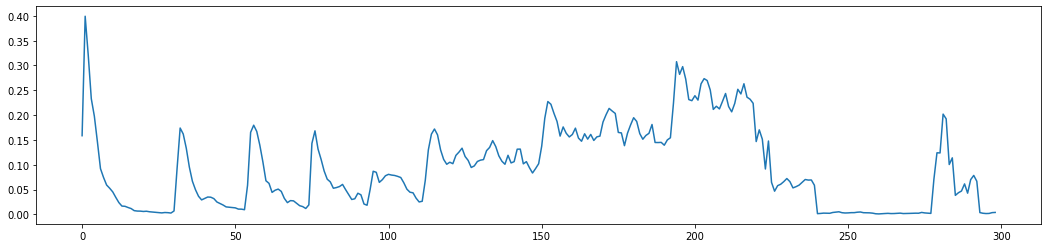

In [24]:
plt.figure(figsize=(18,4))
plt.plot(sfm)
plt.show()

Spectral envelope

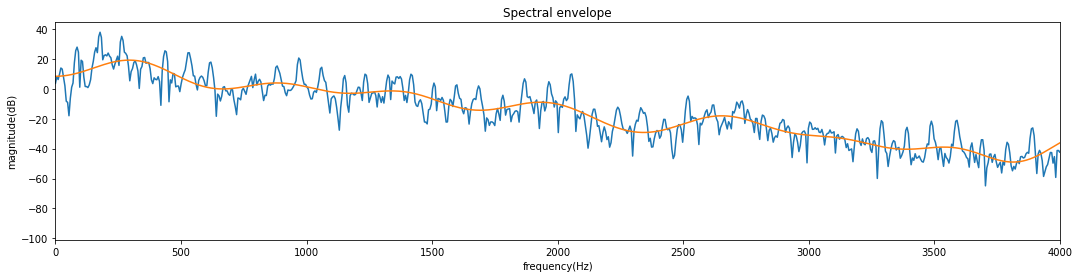

In [31]:
# cepstral analysis

k = np.shape(audio)[0] // 2
hop_length = 512
X = np.fft.fft(audio[100:100 + n_fft] * np.hanning(n_fft))
# n_fft == 8192

c_r = np.fft.ifft(20 * np.log10(np.abs(X))).real
N1 = 100
window_lowpass = np.array([1] + [2] * N1 + [0] * (len(c_r) - 1 - N1))
c_lowpass = c_r * window_lowpass
c_lowpass = np.fft.fft(c_lowpass)
fi = np.arange(0, sr // 2, sr / n_fft)
plt.figure(figsize=(18,4))
plt.plot(fi, 20 * np.log10(np.abs(X[:n_fft//2]) + np.finfo(float).eps))
plt.plot(fi, c_lowpass[:n_fft//2].real)
plt.xlim([0,4000])
plt.title('Spectral envelope')
plt.xlabel('frequency(Hz)')
plt.ylabel('magnitude(dB)')
plt.show()

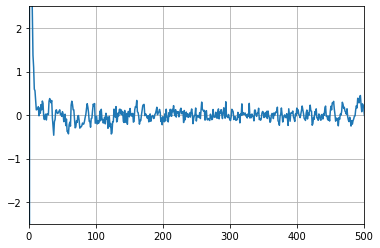

In [34]:
plt.plot(c_r)
plt.xlim([0,500])
plt.ylim([-2.5,2.5])
plt.grid()
plt.show()


compute and plot MFCC

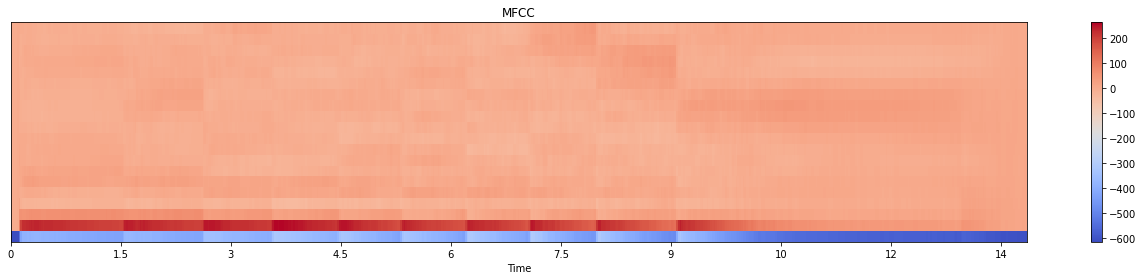

In [35]:
mfcc = librosa.feature.mfcc(y=audio, sr=sr)
plt.figure(figsize=(18,4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# lab2 - 2 : Tonal features (cqt & chromagram)

compute and plot constant-Q transform

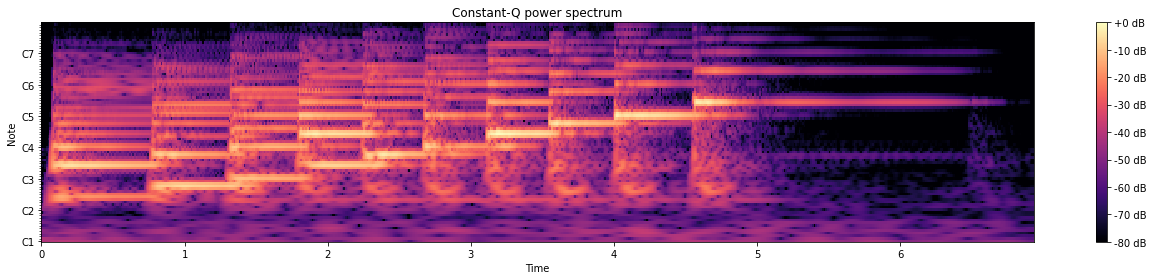

In [36]:
C = np.abs(librosa.cqt(y=audio, sr=sr))
plt.figure(figsize=(18,4))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()
plt.show()

compute and plot chromagram

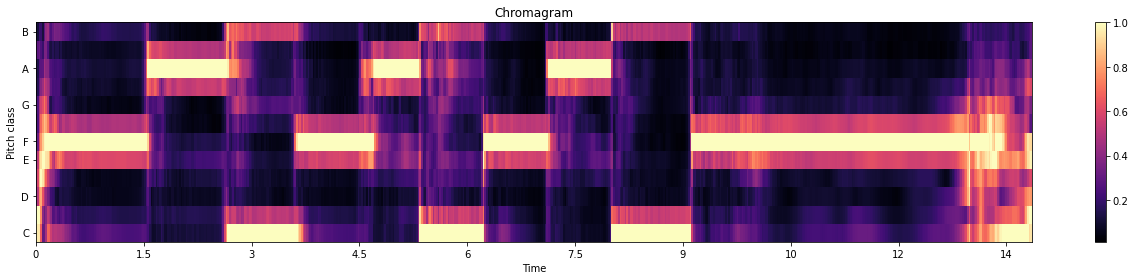

In [39]:
chromagram = librosa.feature.chroma_cqt(y=audio, sr=sr)
plt.figure(figsize=(18,4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()